# Metric Analysis for ECON model

In [1]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
import torchinfo
import numpy as np
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
import os
import sys

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from gradient import Gradient
from hessian import Hessian
from CKA import CKA



/home/tbaldi/miniconda3/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Select the desired ECON model:

In [2]:
base_path = "/data/tbaldi/checkpoint/"
batch_size = 1024
learning_rate = 0.1
precision = 8
size = 'small'

In [3]:
def load_model(path, batch_size, learning_rate, precision, size):
    model_path = path + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_1_best.pkl'
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    print(model_path)
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    return model


model = load_model(base_path, batch_size, learning_rate, precision, size)
torchinfo.summary(model, input_size=(1, 1, 8, 8))  # (B, C, H, W)     

/data/tbaldi/checkpoint/bs1024_lr0.1/ECON_8b/small/net_1_best.pkl


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 8, 8]              --
├─QuantizedEncoder: 1-1                  [1, 16]                   --
│    └─QuantAct: 2-1                     [1, 1, 8, 8]              --
│    └─QuantConv2d: 2-2                  [1, 1, 4, 4]              20
│    └─ReLU: 2-3                         [1, 1, 4, 4]              --
│    └─QuantAct: 2-4                     [1, 1, 4, 4]              --
│    └─Flatten: 2-5                      [1, 16]                   --
│    └─QuantLinear: 2-6                  [1, 16]                   272
│    └─ReLU: 2-7                         [1, 16]                   --
├─Sequential: 1-2                        [1, 1, 8, 8]              --
│    └─Linear: 2-8                       [1, 128]                  2,176
│    └─ReLU: 2-9                         [1, 128]                  --
│    └─Unflatten: 2-10                   [1, 8, 4, 4]              --
│    └─Conv

Setup the data loader:

In [4]:
data_path = '../../data/ECON/Elegun'
processed_file = 'nELinks5.npy'

def get_data_module(batch_size):
    data_module = AutoEncoderDataModule(
        data_dir=data_path,
        data_file=os.path.join(data_path, processed_file),
        batch_size=batch_size,
        num_workers=4
        )
    # checek if we have processed the data
    if not os.path.exists(os.path.join(data_path, processed_file)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

data_module = get_data_module(batch_size)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


Model performances:

In [5]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

# TODO: add the possibility to load the EMD from file
def compute_EMD(size, precision, bs, lr, load=True):
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader(), verbose=False)
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    print("AVG EMD: ", avg_emd)
    

# compute_EMD('small', 8, batch_size, learning_rate)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## CKA similarity

Extract the features from each layer of the model:

In [6]:
model = load_model(base_path, batch_size, learning_rate, 8, 'small')
data_module = get_data_module(batch_size)

/data/tbaldi/checkpoint/bs1024_lr0.1/ECON_8b/small/net_1_best.pkl
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


In [7]:
metric = CKA(model, 
             data_module.test_dataloader(),
             activation_layers=['encoder.relu1', 'encoder.relu2'])

result = metric.compute()


Computing the CKA similarity...


[[0.         0.44567594]
 [0.44567594 0.        ]]


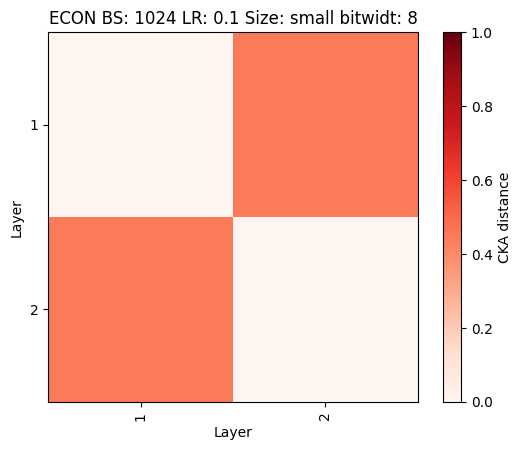

In [8]:
def plot_cka_heatmap(cka_values, title, x_label='Layer', y_label='Layer'):
    # Create a heatmap
    plt.imshow(cka_values, 
            cmap='Reds', 
            interpolation='nearest',
            vmin=0,
            vmax=1)

    # Customize the plot
    plt.colorbar(label='CKA distance')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Get the dimensions of the matrix
    rows, cols = cka_values.shape

    # Set axis ticks based on the dimensions
    plt.xticks(np.arange(cols), np.arange(1, cols + 1), rotation='vertical')
    plt.yticks(np.arange(rows), np.arange(1, rows + 1))

    # Display the plot
    plt.show()
    
plot_cka_heatmap(result['cka_dist'], 
                 f"ECON BS: {batch_size} LR: {learning_rate} Size: {size} bitwidt: {precision}")

/data/tbaldi/checkpoint/bs1024_lr0.1/ECON_8b/small/net_1_best.pkl
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
/data/tbaldi/checkpoint/bs1024_lr0.1/ECON_11b/small/net_1_best.pkl
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
[[0.00523799 0.40378892]
 [0.44436368 0.89896368]]


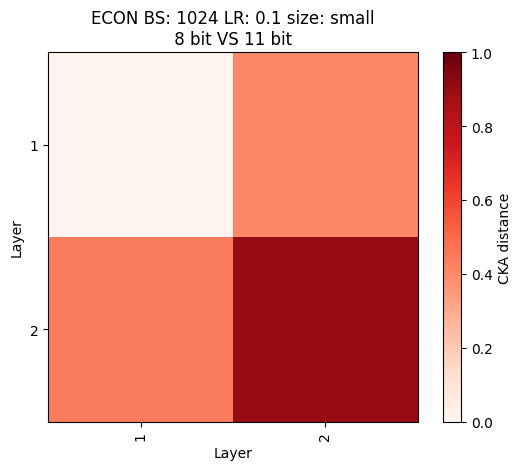

In [9]:
model_small = load_model(base_path, batch_size, learning_rate, 8, 'small')
data_module_small = get_data_module(batch_size)

model_baseline = load_model(base_path, batch_size, learning_rate, 11, 'small')
data_module_baseline = get_data_module(batch_size)

activation_layers=['encoder.relu1', 'encoder.relu2']

metric = CKA(model_small, 
             data_module_small.test_dataloader(),
             activation_layers=activation_layers)

result = metric.compare(model_baseline, 
                        data_module_baseline.test_dataloader(), 
                        activation_layers)


plot_cka_heatmap(result['cka_dist'], 
                 f"ECON BS: {batch_size} LR: {learning_rate} size: {size}\n 8 bit VS 11 bit ")


## Hessian 

In [10]:
# %reload_ext autoreload
# %autoreload 2

# _, val_loader = data_module.dataloaders()

# metric = Hessian(
#     model=model,
#     data_loader=val_loader,
#     loss=model.loss
# )

# results = metric.compute()
# results

In [11]:
# metric.save_on_file(path=".")

In [12]:
# result = metric.load_from_file(path=".")

# result